# Задание 1.0

## Подключаем нужные библиотеки

In [66]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

## Загружаем Dataset

Цена на золото за 10 лет

    Date:   дата торгов
    Close:  цена закрытия
    Volume: объем торгов в течение дня
    Open:   цена открытия
    High:   наивысшая цена за день
    Low:    наименьшая цена за день

Дополнительно для анализа были добавлены два столбца

    High_Low:   разница между наивысшой и наименьшой ценой
    Open_Close: разница между ценами открытия и закрытия

In [5]:
df = pd.read_csv("d:/goldstock.csv")
df = df.assign(High_Low=df["High"]-df["Low"], Open_Close=df["Open"]-df["Close"])
df = df.drop(columns=["Unnamed: 0"])
df['Date'] = pd.to_datetime(df['Date']) # заменяю дату как строковый объект на тип Date
df.head()



,Date,Close,Volume,Open,High,Low,High_Low,Open_Close
0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2,19.7,-1.9
1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7,17.9,-12.5
2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6,31.5,25.2
3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6,35.2,23.2
4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1,34.2,-18.4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2511 non-null   datetime64[ns]
 1   Close       2511 non-null   float64       
 2   Volume      2511 non-null   float64       
 3   Open        2511 non-null   float64       
 4   High        2511 non-null   float64       
 5   Low         2511 non-null   float64       
 6   High_Low    2511 non-null   float64       
 7   Open_Close  2511 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 157.1 KB


# Задание 1.1
Выбрать и обосновать метрику для измерения качества

Комментарий: В рамках данного пункта необходимо подобрать наиболее релевантную метрику или набор метрик для вашей задачи, написав краткое обоснование (1-2 предложения). 

Критерии оценки:

- Предложена метрика - 5 баллов
- Присутствует корректное обоснование - 5 баллов

Ответ: Для выполения задания был выбран дата-сет для предсказания значений. Таким образом потребуются метрики для задач регрессии: MSE & RMSE, MAE или/и MAPE. В 1.3 будут рассмтренны все, чтобы проанализовать и сравнить. В случае, если будут сильные выбросы в выборке при эксполоритарном анализе, то MSE метрика будет слишко штрафовать и не даст оценить.

# Задание 1.2

Провести EDA на своих данных

Комментарий: В рамках данного пункта необходимо провести предварительный разведочный анализ своего набора данных.

Критерии оценки:

- Рассмотрены базовые характеристики/статистики для набора данных - 2 балла
- Реализованы наиболее релевантные визуализации - 4 балла
- По ходу работы присутствуют комментарии (вы, как эксперт в предметной области, можете проинтерпретировать полученные результаты анализа, сделав выводы о том, каким образом лучше работать с набором данных в будущем, какие могут возникнуть проблемы, какую предобработку целесообразно сделать и тп) - 4 балла
- Продемонстрировать использование библиотеки plotly для визуализации

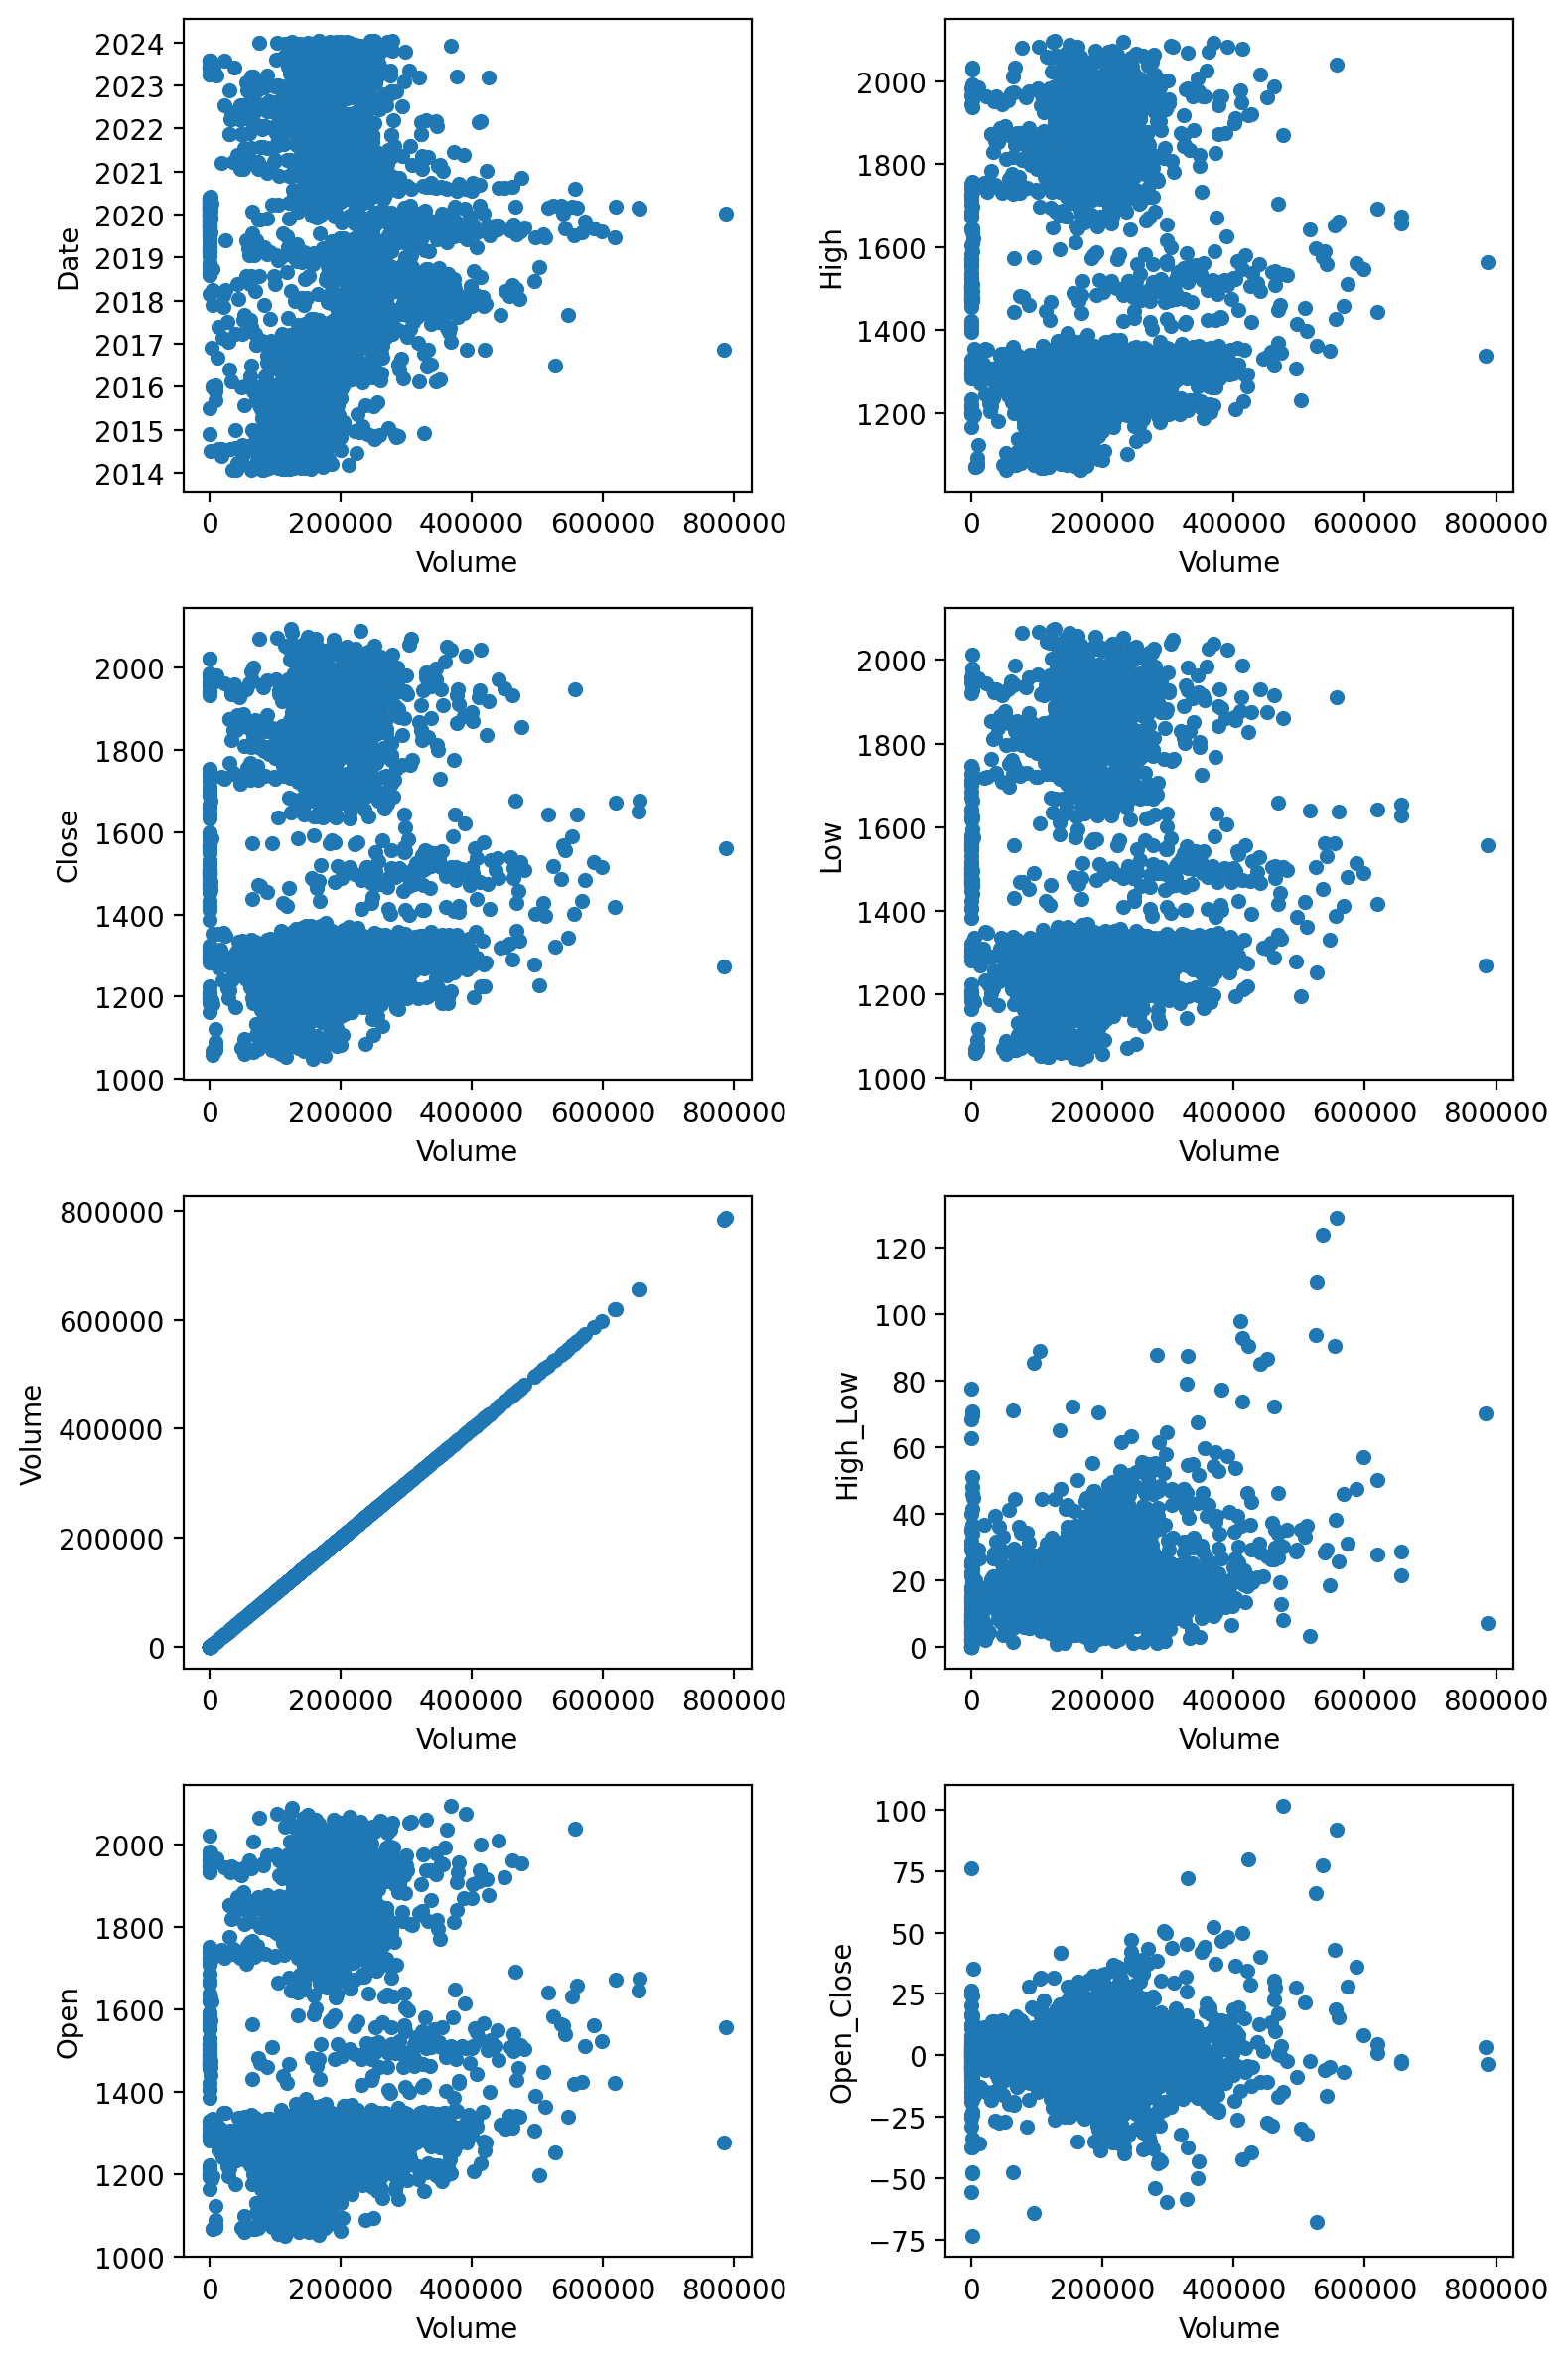

In [7]:
fig, axes = plt.subplots(figsize=(8,12), ncols=2, nrows=4, dpi=200)
for i, f in enumerate(df):
    df.plot("Volume", f, subplots=True, kind='scatter', ax = axes[i%4, i//4])
plt.tight_layout()

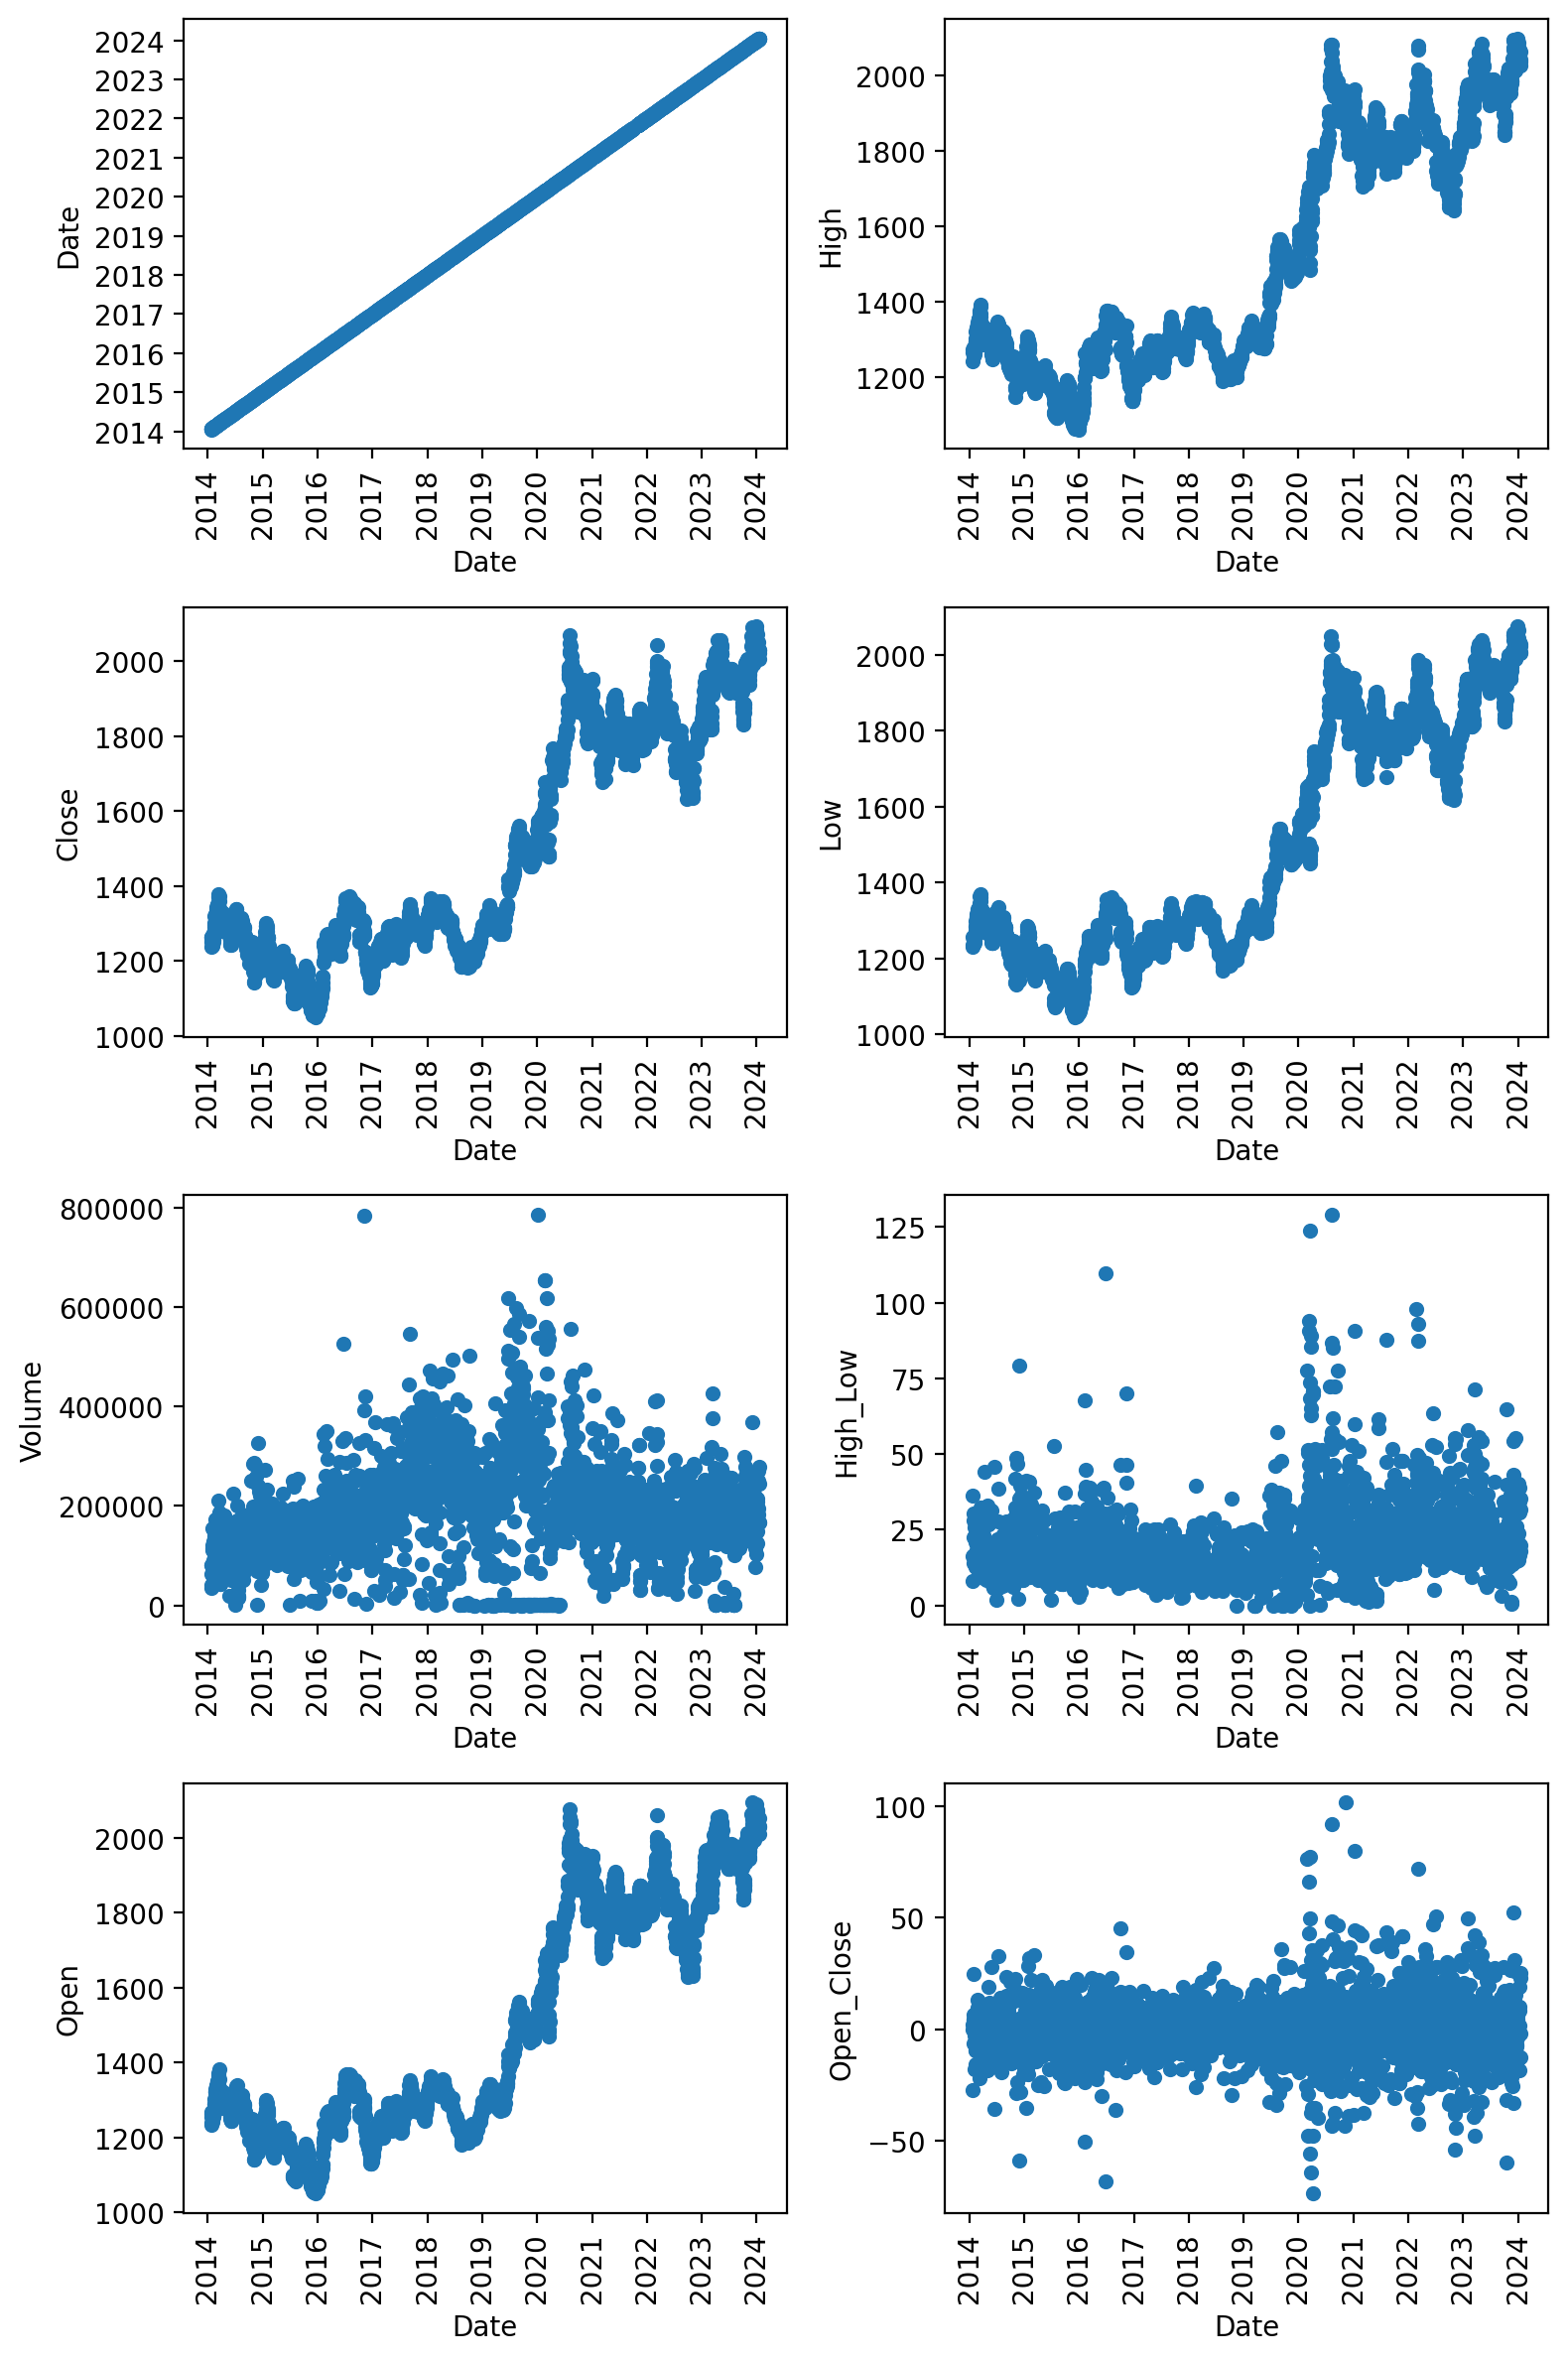

In [8]:
fig, axes = plt.subplots(figsize=(8,12), ncols=2, nrows=4, dpi=200)
for i, f in enumerate(df):
    df.plot("Date", f, subplots=True, kind='scatter', ax = axes[i%4, i//4])
    axes[i%4, i//4].tick_params(axis='x', labelrotation=90)
plt.tight_layout()

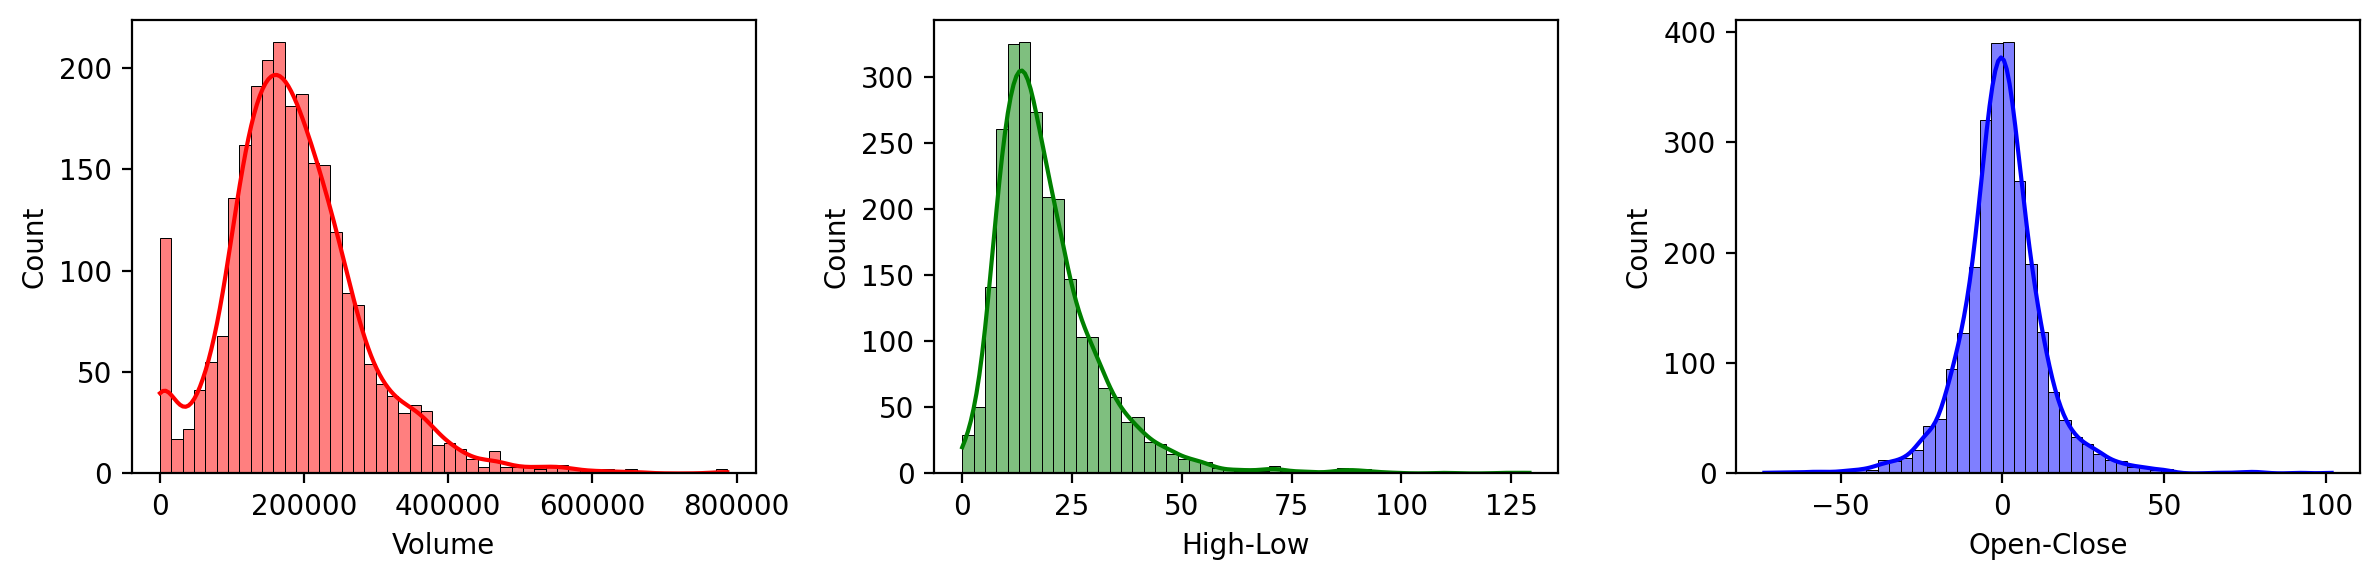

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 3), dpi=200)
sns.histplot(df["Volume"], bins=50, kde=True, color='r', ax=axes[0])
sns.histplot((df["High_Low"]), bins=50, kde=True, color='g', ax=axes[1])
sns.histplot((df["Open_Close"]), bins=50, kde=True, color='b', ax=axes[2])
axes[1].set_xlabel("High-Low")
axes[2].set_xlabel("Open-Close")
plt.tight_layout()

<Axes: >

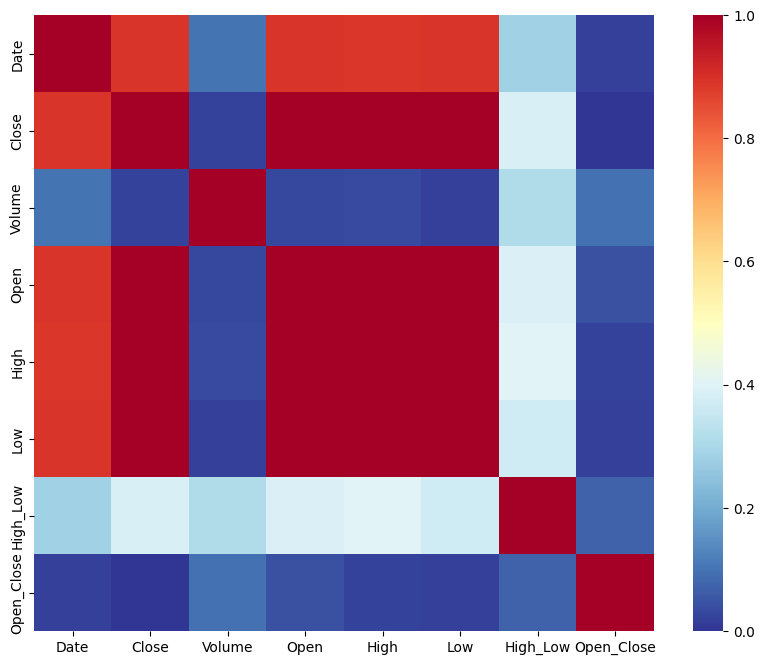

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="RdYlBu_r", )

Выводы по эксплоритарному анализу: не было обнаружено каких либо корелляций. У разниц у спредов (High_Low) и (Open_close), а также объем торгов имееют стандартное распределение.

## Задание 1.3

Построить и оценить качество бейзлайна

Комментарий: В рамках данного пункта необходимо выбрать и обучить бейзлайн-модель, а также измерить ее качество.

Критерии оценки:

- Произведено измерение качества константного предсказания (например, наиболее частотный класс для классификации, среднее/медиана для регрессии) - 3 балла
- Бейзлайновая модель обучена на тренировочной выборке, учтены особенности предобработки данных для модели, если они есть - 5 балла
- Произведено измерение качества на отложенной выборке с использованием ранее выбранной метрики - 2 балла
- Продемонстрировать использование библиотеки plotly для визуализации

In [40]:
df_test = df.drop(columns="Open")
df_test["Date"] = pd.to_datetime(df_test["Date"]).dt.strftime("%Y%m%d").astype(int) # для регрессии заменил дату на число 2012-01-01-> 20120101
X, y = df_test["Date"], df["Open"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.25)
X_train.head()

2297    20141124
573     20211004
536     20211124
233     20230214
2313    20141031
Name: Date, dtype: int32

In [113]:
X, y = df["Date"], df["Open"]
t_split = TimeSeriesSplit(n_splits=2)
train, test = t_split.split (X, y)
n_split = 1
i_train, i_test = train[n_split], test[n_split]

0       20240119
1       20240118
2       20240117
3       20240116
4       20240112
          ...   
2506    20140128
2507    20140127
2508    20140124
2509    20140123
2510    20140122
Name: Date, Length: 2511, dtype: int32

<Axes: ylabel='Density'>

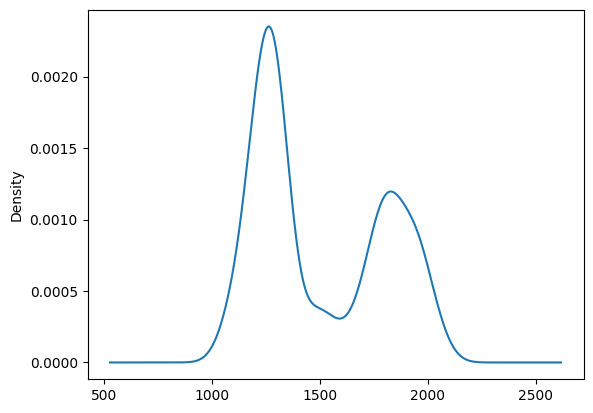

In [41]:
y.plot(kind='kde')

In [42]:
dummy = DummyRegressor(strategy='median')
dummy.fit(X_train, y_train)
y_preds_dummy = dummy.predict(X_test)

In [56]:
lr = LinearRegression()
lr.fit(X_train.to_numpy().reshape((-1, 1)), y_train)
y_preds_lr = lr.predict(X_test.to_numpy().reshape((-1, 1)))

In [57]:
print(f'MSE for Dummy Regressor: {mean_squared_error(y_test, y_preds_dummy)}')
print(f'MSE for Linear regression: {mean_squared_error(y_test, y_preds_lr)}')

MSE for Dummy Regressor: 119389.87406050955
MSE for Linear regression: 17181.959146738605


In [58]:
print(f'RMSE for Dummy Regressor: {mean_squared_error(y_test, y_preds_dummy, squared=False)}')
print(f'RMSE for Linear regression: {mean_squared_error(y_test, y_preds_lr, squared=False)}')

RMSE for Dummy Regressor: 345.5283983415973
RMSE for Linear regression: 131.07997233268935


In [59]:
def plot_model_results(actual, predicted, title):
  results = pd.DataFrame({'True': actual, 'Prediction': predicted})
  sns.lmplot(x='True', y='Prediction', data=results, fit_reg=False)
  d_line= np.arange(results.min().min(), results.max().max())
  plt.plot(d_line, d_line, color='red', linestyle='--')
  plt.title = title
  plt.grid()
  plt.show()

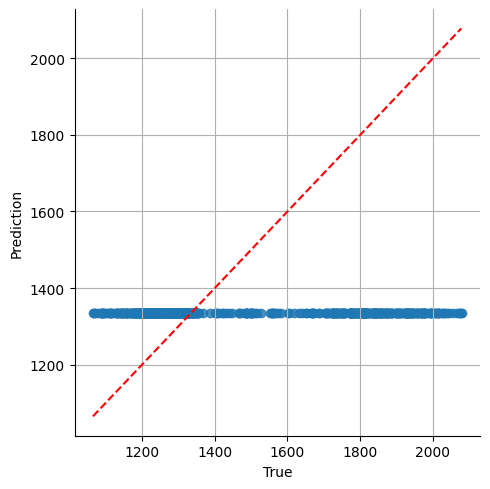

In [60]:
plot_model_results(y_test, y_preds_dummy, title='Dummy')

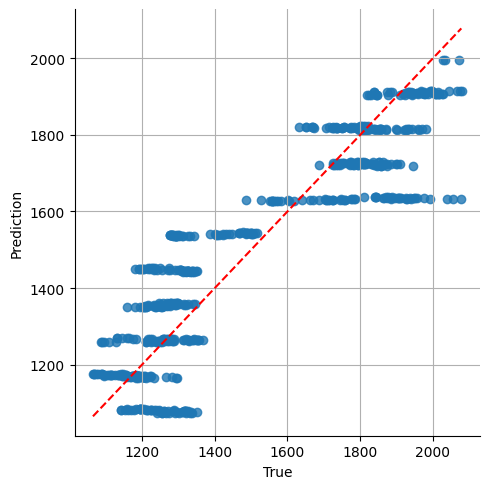

In [61]:
plot_model_results(y_test, y_preds_lr, title='Linear Regression')

In [62]:
print(f'MAE for Dummy Regressor: {mean_absolute_error(y_test, y_preds_dummy)}')
print(f'MAE for Linear regression: {mean_absolute_error(y_test, y_preds_lr)}')

MAE for Dummy Regressor: 266.2265923566879
MAE for Linear regression: 104.60094218982796


In [63]:
print(f'MAPE for Dummy Regressor: {mean_absolute_percentage_error(y_test, y_preds_dummy)}')
print(f'MAPE for Linear regression: {mean_absolute_percentage_error(y_test, y_preds_lr)}')

MAPE for Dummy Regressor: 0.15894442070534234
MAPE for Linear regression: 0.07239938296108636


In [64]:
print(f'R2 score for Dummy Regressor: {r2_score(y_test, y_preds_dummy)}')
print(f'R2 score for Linear regression: {r2_score(y_test, y_preds_lr)}')

R2 score for Dummy Regressor: -0.3140631165789671
R2 score for Linear regression: 0.8108869871673314


Выводы по Задаче 1.3: обученная модель Linear  regression показала самый лучший результат, метрика R2 равная 1 считается идеальной.